In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip
/kaggle/input/glove6b50dtxt/glove.6B.50d.txt


In [2]:
!unzip ../input/jigsaw-toxic-comment-classification-challenge/train.csv.zip
!unzip ../input/jigsaw-toxic-comment-classification-challenge/test.csv.zip
!unzip ../input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip
!unzip ../input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip

Archive:  ../input/jigsaw-toxic-comment-classification-challenge/train.csv.zip
  inflating: train.csv               
Archive:  ../input/jigsaw-toxic-comment-classification-challenge/test.csv.zip
  inflating: test.csv                
Archive:  ../input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip
  inflating: test_labels.csv         
Archive:  ../input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip
  inflating: sample_submission.csv   


In [3]:
TRAIN = './train.csv'
TEST = './test.csv'
TEST_LABEL = './test_labels.csv'
SAMPLE = './sample_submission.csv'

In [4]:
train_csv = pd.read_csv(TRAIN)
test_csv = pd.read_csv(TEST)
test_label = pd.read_csv(TEST_LABEL)
sample_sub = pd.read_csv(SAMPLE)
train_csv.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
train_csv.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


## EDA(Exploratory data analysis) by performing data visualization
adapted from kernel:https://www.kaggle.com/vippatil/toxic-comment-using-lstm

Text(0.5, 0, 'Labels')

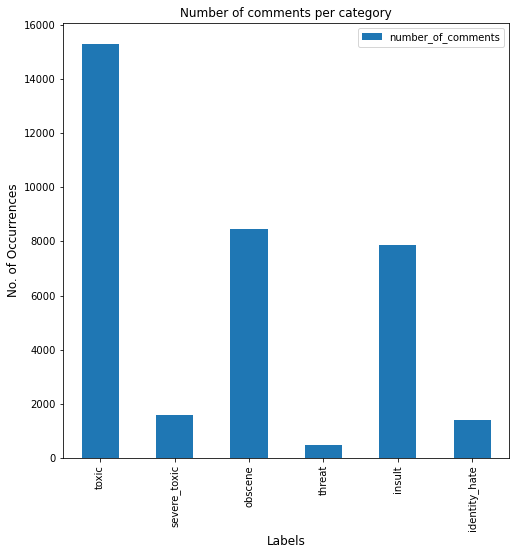

In [30]:
import matplotlib
import matplotlib.pyplot as plt
### Removed unnecessary columns - id and comment_text
categorywise_data = train_csv.drop(['id', 'comment_text'], axis=1)     
counts_category = []                                               ### A list that contains tuple which consists of class label and number of comments for that particular class 
categories = list(categorywise_data.columns.values)
for i in categories:
    counts_category.append((i, categorywise_data[i].sum()))
    
dataframe = pd.DataFrame(counts_category, columns=['Labels', 'number_of_comments'])  
dataframe.plot(x='Labels', y='number_of_comments', kind='bar',figsize=(8,8))
plt.title("Number of comments per category")
plt.ylabel('No. of Occurrences', fontsize=12)
plt.xlabel('Labels', fontsize=12)

,0,Total no. of sentences,Total No. of labels in a sentence
0,143346,143346,0
1,6360,6360,1
3,4209,4209,3
2,3480,3480,2
4,1760,1760,4
5,385,385,5
6,31,31,6


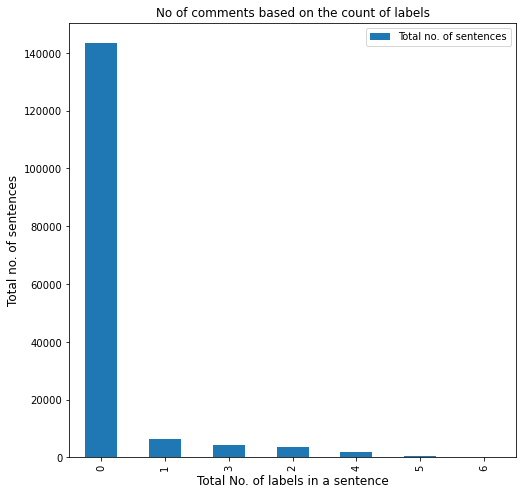

In [39]:
### This visualization is helpful in identifying whether a sentence belongs to only one category or many categories

dataframe = pd.DataFrame(pd.DataFrame(train_csv[train_csv.columns[2:]].sum(axis=1)).reset_index()[0].value_counts())
dataframe["Total no. of sentences"]=dataframe[0]
dataframe["Total No. of labels in a sentence"]=dataframe.index
dataframe.plot(x="Total No. of labels in a sentence", y="Total no. of sentences", kind='bar',figsize=(8,8))
plt.title("No of comments based on the count of labels")
plt.ylabel('Total no. of sentences', fontsize=12)
plt.xlabel('Total No. of labels in a sentence', fontsize=12)
dataframe

### From the below graph we can see that 1,43,346 out of 1,59,571 sentences does not have any labels(class 0).
### we can observe that a single sentence can have multiple labels. It can be a toxic sentence or it can be a toxic as well as obscene senetence.

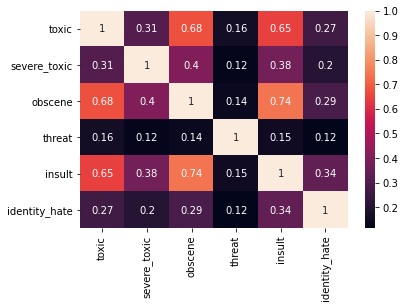

In [33]:
### Correlation between different variables
### Correlation helps us finding relationship/dependency between different variables. 
import seaborn as sns
target_data = train_csv.drop(['id', 'comment_text'], axis=1)
corrMatrix = target_data.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

## LSTM
adapted from the kernel: https://www.kaggle.com/jhoward/improved-lstm-baseline-glove-dropout

In [6]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

In [7]:
## set config parameters:
embed_size = 50 # how big is each word vector
max_features = 20000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a comment to use

In [8]:
# replace missing values:
list_sentences_train = train_csv["comment_text"].fillna("_na_").values
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train_csv[list_classes].values
list_sentences_test = test_csv["comment_text"].fillna("_na_").values

In [9]:
# Standard keras preprocessing, to turn each comment into a list of word indexes of equal length (with truncation or padding as needed).
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_train = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_test = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [10]:
# Read the glove word vectors (space delimited strings) into a dictionary from word->vector.
path = '../input/'
EMBEDDING_FILE=f'{path}glove6b50dtxt/glove.6B.50d.txt'
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE))

In [11]:
# Use these vectors to create our embedding matrix, with random initialization for words that aren't in GloVe. 
# We'll use the same mean and stdev of embeddings the GloVe has when generating the random init.

glove_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = glove_embs.mean(), glove_embs.std()
emb_mean,emb_std

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3347: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


(0.020940498, 0.6441043)

In [12]:
word_index = tokenizer.word_index
len(word_index)

210337

In [13]:
nb_words = min(max_features, len(word_index))
# Draw random samples from a normal (Gaussian) distribution. random.normal(loc=0.0, scale=1.0, size=None)
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
embedding_matrix

array([[ 0.2398842 ,  1.46083972, -0.15618059, ...,  0.61890359,
         0.98437998,  0.66574427],
       [ 0.51437991,  0.45386186, -0.7704211 , ...,  0.15807685,
         0.57488366,  0.89509699],
       [-1.04240052, -0.13138791, -0.33677386, ...,  0.26910588,
        -0.28804088,  0.54840852],
       ...,
       [ 0.07296534, -0.11010428,  0.30210191, ...,  0.19074691,
        -0.91526312,  0.00360767],
       [-0.50817834,  0.21966568, -0.31999179, ..., -0.5976313 ,
        -0.96600222,  0.12856201],
       [ 0.27708423,  0.77697561,  0.535414  , ..., -0.57237321,
        -0.09408983, -1.38101898]])

In [14]:
# Prepare embedding matrix

for word, i in word_index.items():
    if i >= max_features: 
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: 
        # Words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [15]:
# Simple bidirectional LSTM with two fully connected layers. 
# add some dropout to the LSTM since even 2 epochs is enough to overfit.

inp = Input(shape=(maxlen,))
# load the pre-trained word embeddings matrix into an Embedding layer.
#embedding_layer = Embedding(num_tokens,embedding_dim,embeddings_initializer=keras.initializers.Constant(embedding_matrix))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 50)           1000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 100)          40400     
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                5050      
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 306   

In [16]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [17]:
model.fit(X_train, y, batch_size=32, epochs=15, validation_split=0.1)


Epoch 1/15
4488/4488 [==============================] - 831s 184ms/step - loss: 0.0793 - accuracy: 0.8934 - val_loss: 0.0504 - val_accuracy: 0.9940
Epoch 2/15
4488/4488 [==============================] - 800s 178ms/step - loss: 0.0451 - accuracy: 0.9636 - val_loss: 0.0459 - val_accuracy: 0.9933
Epoch 3/15
 505/4488 [==>...........................] - ETA: 11:35 - loss: 0.0390 - accuracy: 0.9603

KeyboardInterrupt: 

In [43]:
y_test = model.predict(X_test)

In [ ]:
# get predictions for the test set and prepare a submission CSV
sample_sub[list_classes] = y_test
sample_sub.to_csv('submission.csv', index=False)

In [41]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=1024)
print("test loss, test acc:", results)

Evaluate on test data
150/150 [==============================] - 41s 272ms/step - loss: 0.0900 - accuracy: 1.0000
test loss, test acc: [0.08995161205530167, 0.9999934434890747]


In [44]:
sample_sub[list_classes] = y_test
sample_sub[1030:1050]

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
1030,01b5e563c409eeb5,0.998353,5.394126e-01,0.987168,7.073969e-02,0.899033,0.479302
1031,01b61a5a8cab9bbf,0.000443,5.377103e-06,0.000357,3.868943e-06,0.000091,0.000051
1032,01b6b98045d98876,0.729487,8.314550e-03,0.422878,6.237268e-03,0.209304,0.059892
1033,01b6e742f65738d4,0.304722,1.446307e-03,0.093336,2.083004e-03,0.054800,0.037802
1034,01b78a621cff00a1,0.042214,6.444556e-05,0.005613,1.382232e-04,0.005710,0.000514
1035,01b83a5c904402b8,0.001787,2.947501e-05,0.000731,3.711270e-05,0.000323,0.001102
1036,01b85ab3638dc00c,0.989805,1.379786e-01,0.911773,2.504140e-02,0.792888,0.045295
1037,01b973f3285aee88,0.962474,1.111108e-01,0.856963,2.650768e-02,0.555883,0.034916
1038,01ba37552b3c7b68,0.947065,1.159643e-01,0.544056,1.260407e-01,0.712208,0.187617
1039,01ba472e48b261d8,0.056244,1.874566e-04,0.008252,3.815889e-04,0.009495,0.009455
